In [2]:
import calendar #used to calculate N, number of days in a month#
import math
import datetime
import numpy as np
#import cudf
#%load_ext cudf.pandas #NVIDIA to make Pandas run faster
import pandas as pd
#import netCDF4 as nc
import geopandas as gpd
import matplotlib.pyplot as plt #to plot the maps
import cartopy.crs as crs
import csv
#import netCDF4
#from netCDF4 import Dataset

In [3]:
merged = pd.read_csv("/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/HDM4/CRU/Converted/merged_2011_20.csv")

In [4]:
data = merged

In [5]:
data

,Unnamed: 0,Unnamed: 0_left,Lat,Lon,Time,Year,Month,Day_left,Precipitation,Unnamed: 0_right,Day_right,Temperature
0,0,0,-89.75,-179.75,2011-01-16 00:00:00,2011,1,16,NaN,0,16,NaN
1,1,1,-89.75,-179.25,2011-01-16 00:00:00,2011,1,16,NaN,1,16,NaN
2,2,2,-89.75,-178.75,2011-01-16 00:00:00,2011,1,16,NaN,2,16,NaN
3,3,3,-89.75,-178.25,2011-01-16 00:00:00,2011,1,16,NaN,3,16,NaN
4,4,4,-89.75,-177.75,2011-01-16 00:00:00,2011,1,16,NaN,4,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
31103995,31103995,31103995,89.75,177.75,2020-12-16 00:00:00,2020,12,16,NaN,31103995,16,NaN
31103996,31103996,31103996,89.75,178.25,2020-12-16 00:00:00,2020,12,16,NaN,31103996,16,NaN
31103997,31103997,31103997,89.75,178.75,2020-12-16 00:00:00,2020,12,16,NaN,31103997,16,NaN
31103998,31103998,31103998,89.75,179.25,2020-12-16 00:00:00,2020,12,16,NaN,31103998,16,NaN


In [6]:
data.rename(columns={'Day_left': 'Day'}, inplace=True)

In [7]:
#Remove rows with Temperature and Precipitation = NaN
data = data.dropna(subset=['Temperature', 'Precipitation'], how='all')

In [8]:
data['Prp'] = data['Precipitation']*0.1

/var/folders/pr/_06pztgj1tvf2n01hdjmhbxc0000gn/T/ipykernel_5741/4082249935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prp'] = data['Precipitation']*0.1


In [9]:
data['Lat_r'] = data['Lat']* math.pi/180

/var/folders/pr/_06pztgj1tvf2n01hdjmhbxc0000gn/T/ipykernel_5741/689104367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lat_r'] = data['Lat']* math.pi/180


In [10]:
def collect_sol_dec(Day):
    """
    Calculate solar declination from day of the year.

    Based on FAO equation 24 in Allen et al (1998).

    :param day_of_year: Day of year integer between 1 and 365 or 366).
    :return: solar declination [radians]
    :rtype: float
    """
    #_check_doy(day_of_year)
    return 0.409 * math.sin(((2.0 * math.pi / 365.0) * Day - 1.39))

In [11]:
def collect_sunset_hour_angle(Lat_r, sol_dec):
    """
    Calculate sunset hour angle (*Ws*) from latitude and solar
    declination.

    Based on FAO equation 25 in Allen et al (1998).

    :param latitude: Latitude [radians]. Note: *latitude* should be negative
        if it in the southern hemisphere, positive if in the northern
        hemisphere.
    :param sol_dec: Solar declination [radians]. Can be calculated using
        ``sol_dec()``.
    :return: Sunset hour angle [radians].
    :rtype: float
    """
    #_check_latitude_rad(latitude)
    #_check_sol_dec_rad(sol_dec)

    cos_sha = -math.tan(Lat_r) * math.tan(sol_dec)
    # If tmp is >= 1 there is no sunset, i.e. 24 hours of daylight
    # If tmp is <= 1 there is no sunrise, i.e. 24 hours of darkness
    # See http://www.itacanet.org/the-sun-as-a-source-of-energy/
    # part-3-calculating-solar-angles/
    # Domain of acos is -1 <= x <= 1 radians (this is not mentioned in FAO-56!)
    return math.acos(min(max(cos_sha, -1.0), 1.0))

In [12]:
#Calculate daylight hours #from: https://github.com/woodcrafty/PyETo/blob/master/pyeto/fao.py
def collect_daylight_hours(sha):
    """
    Calculate daylight hours from sunset hour angle.

    Based on FAO equation 34 in Allen et al (1998).

    :param sha: Sunset hour angle [rad]. Can be calculated using
        ``sunset_hour_angle()``.
    :return: Daylight hours.
    :rtype: float
    """
   # _check_sunset_hour_angle_rad(sha)
    return (24.0 / math.pi) * sha

In [13]:
#Calculate Solar declination
data['sol_dec'] = data['Day'].apply(collect_sol_dec)

/var/folders/pr/_06pztgj1tvf2n01hdjmhbxc0000gn/T/ipykernel_5741/491838344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sol_dec'] = data['Day'].apply(collect_sol_dec)


In [14]:
data['sha'] = data.apply(lambda row: collect_sunset_hour_angle(row['Lat_r'], row['sol_dec']), axis=1)

/var/folders/pr/_06pztgj1tvf2n01hdjmhbxc0000gn/T/ipykernel_5741/3299640532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sha'] = data.apply(lambda row: collect_sunset_hour_angle(row['Lat_r'], row['sol_dec']), axis=1)


In [15]:
#Calculate 'd', number of daylight hours per day
data['d'] = data['sha'].apply(collect_daylight_hours)

/var/folders/pr/_06pztgj1tvf2n01hdjmhbxc0000gn/T/ipykernel_5741/411618118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['d'] = data['sha'].apply(collect_daylight_hours)


In [16]:
data = data.drop(['Unnamed: 0_left', 'Unnamed: 0_right', 'Unnamed: 0', 'Day_right'], axis=1)

In [17]:
#Calculate I
# Define a function to calculate monthly 'i'
def calculate_i(Temperature):
    if Temperature < 0: #Thornthwaite and Mather, 1957
        i = 0
    else:
        
        i = (0.2 * Temperature) ** 1.514 #This equation only applies for temperature >= 0 deg Celsius
    return i

data['i'] = data['Temperature'].apply(calculate_i)

data['I'] = data.groupby(['Lat', 'Lon', 'Year'])['i'].transform('sum')

In [18]:
data

,Lat,Lon,Time,Year,Month,Day,Precipitation,Temperature,Prp,Lat_r,sol_dec,sha,d,i,I
49183,-55.75,-68.25,2011-01-16 00:00:00,2011,1,16,99.9,8.100000,9.99,-0.973021,-0.367169,2.171077,16.585810,2.075897,14.911264
49184,-55.75,-67.75,2011-01-16 00:00:00,2011,1,16,95.5,8.300000,9.55,-0.973021,-0.367169,2.171077,16.585810,2.153990,15.214838
49185,-55.75,-67.25,2011-01-16 00:00:00,2011,1,16,96.0,7.900000,9.60,-0.973021,-0.367169,2.171077,16.585810,1.998788,13.844667
49898,-55.25,-70.75,2011-01-16 00:00:00,2011,1,16,163.2,8.100000,16.32,-0.964294,-0.367169,2.158453,16.489364,2.075897,14.937549
49899,-55.25,-70.25,2011-01-16 00:00:00,2011,1,16,142.3,8.500000,14.23,-0.964294,-0.367169,2.158453,16.489364,2.233056,16.771549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31094938,83.75,-30.75,2020-12-16 00:00:00,2020,12,16,0.1,-31.400000,0.01,1.461713,-0.367169,0.000000,0.000000,0.000000,0.646774
31094939,83.75,-30.25,2020-12-16 00:00:00,2020,12,16,0.1,-30.600000,0.01,1.461713,-0.367169,0.000000,0.000000,0.000000,0.969636
31094940,83.75,-29.75,2020-12-16 00:00:00,2020,12,16,0.1,-29.700000,0.01,1.461713,-0.367169,0.000000,0.000000,0.000000,1.403656
31094941,83.75,-29.25,2020-12-16 00:00:00,2020,12,16,0.1,-30.300001,0.01,1.461713,-0.367169,0.000000,0.000000,0.000000,1.027115


In [19]:
#Calculate PE, see updated equations from: https://www.mdpi.com/1996-1073/14/20/6760 accessed 31/10/23
def calculate_PE(row):
    # Extract the required values from the row
    I = row['I']
    Year = row['Year']
    Month = row['Month']
    d = row['d']
    Temperature = row['Temperature'] #temperature should be in degrees Celsius

    # Check if Temperature is zero and handle it
    if Temperature <= 0: #Thornthwaite and Mather, 1957
        PE = 0
    else:
        # Calculate the coefficient 'a' in the PE equation
        a = ((6.75e-7 * (I ** 3)) - (7.711e-5 * I ** 2) + (0.01792 * I) + 0.49239) #Should range 0<a<4.25

        # Convert 'Year' and 'Month' columns to integers
        year = int(Year)
        month = int(Month)

        # Calculate the adjustment factor in the PE  #Refer to: https://www.researchgate.net/publication/308114644_Review_of_calculation_procedures_of_thornthwaite_moisture_index_and_its_impact_on_footing_design
        N = calendar.monthrange(year, month)[1] #Number of days in calendar month
        f1 = d / 12  #Day length correction factor
        f2 = N / 30.0 #Adjustment factor for number of days per month

        # Calculate PE
        PE = (f1 * f2 * 1.6 * ((10 * Temperature / I) ** a))
    
    return PE

data['PE'] = data.apply(calculate_PE, axis=1) #the unit of PE returned from this equation is cm
#Different methods to calculate PE are in: https://etcalc.hydrotools.tech/pageMain.php

In [20]:
# Alternative method to calculate TMI (simplified) to avoid change in soil water storage
# Method 4 in this paper: [insert your paper link here]
# Calculate the summation of P and PE for each lat, lon, year
groupedS = data.groupby(['Lat', 'Lon', 'Year']).agg({'Prp': 'sum', 'PE': 'sum'}).reset_index()

# Calculate Ih and Ia
groupedS['P'] = groupedS['Prp']
groupedS['Tt_PE'] = groupedS['PE']
groupedS = groupedS[groupedS['Tt_PE'] != 0]#where Tt_PE = 0, the results will not be meaningful

# Calculate TMI if Tt_PE is not equal to 0
groupedS['TMI'] = (75 * ((groupedS['P'] / groupedS['Tt_PE']) - 1)) + 10

# Create a new DataFrame with lat, lon, Ih, and Ia
TMI_new = groupedS[['Lat', 'Lon', 'P', 'Tt_PE', 'TMI', 'Year']]

# Print the resulting DataFrame
print(TMI_new)


          Lat     Lon          P      Tt_PE          TMI  Year
0      -55.75  -68.25  54.100000  67.853766    -5.202287  2011
1      -55.75  -68.25  70.170000  69.657692    10.551599  2012
2      -55.75  -68.25  70.310001  69.768999    10.581564  2013
3      -55.75  -68.25  76.170002  71.088682    15.360895  2014
4      -55.75  -68.25  79.650002  68.278160    22.491375  2015
...       ...     ...        ...        ...          ...   ...
601445  68.75  179.75  28.690000   2.407078   828.926131  2016
601446  68.75  179.75  46.380001   2.326983  1429.854034  2017
601447  68.75  179.75  31.100000   2.566456   843.840721  2018
601448  68.75  179.75  40.250000   2.450155  1167.064980  2019
601449  68.75  179.75  30.990000   2.377620   912.553213  2020

[598878 rows x 6 columns]


In [21]:
TMI_new[(TMI_new.Lat>-1.285)&(TMI_new.Lon>29.6850)]

,Lat,Lon,P,Tt_PE,TMI,Year
129480,-1.25,29.75,135.550000,75.711857,69.275533,2011
129481,-1.25,29.75,127.890000,75.355752,62.286236,2012
129482,-1.25,29.75,131.140000,75.755453,64.832238,2013
129483,-1.25,29.75,130.260000,75.159558,64.983467,2014
129484,-1.25,29.75,132.840001,75.314170,67.285865,2015
...,...,...,...,...,...,...
601445,68.75,179.75,28.690000,2.407078,828.926131,2016
601446,68.75,179.75,46.380001,2.326983,1429.854034,2017
601447,68.75,179.75,31.100000,2.566456,843.840721,2018
601448,68.75,179.75,40.250000,2.450155,1167.064980,2019


In [22]:
# Average TMI
# Calculate the summation of TMIMI for each lat, lon
grouped = TMI_new.groupby(['Lat', 'Lon',]).agg({'TMI': 'mean'}).reset_index()

grouped['tmi'] = grouped['TMI']

# Create a new DataFrame with lat, lon, Ih, and Ia
TMIav = grouped[['Lat', 'Lon', 'tmi',]]

# Print the resulting DataFrame
print(TMIav)


         Lat     Lon          tmi
0     -55.75  -68.25    10.341116
1     -55.75  -67.75     5.573605
2     -55.75  -67.25     6.214668
3     -55.25  -70.75    64.204650
4     -55.25  -70.25    44.952801
...      ...     ...          ...
59907  68.75  177.75  1074.900158
59908  68.75  178.25  1088.219220
59909  68.75  178.75  1059.141150
59910  68.75  179.25  1107.746502
59911  68.75  179.75  1084.276897

[59912 rows x 3 columns]


In [23]:
#Drop rows with inf 
# Replace inf and -inf with NaN
TMIav.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values in the 'TMI' column
TMIav.dropna(subset=['tmi'], inplace=True)


/var/folders/pr/_06pztgj1tvf2n01hdjmhbxc0000gn/T/ipykernel_5741/4216917759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TMIav.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/pr/_06pztgj1tvf2n01hdjmhbxc0000gn/T/ipykernel_5741/4216917759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TMIav.dropna(subset=['tmi'], inplace=True)


In [24]:
max_TMI = TMIav['tmi'].max()
print(max_TMI)

2902.9416115668846


In [25]:
min_TMI = TMIav['tmi'].min()
print("Minimum TMI value:", min_TMI)

Minimum TMI value: -65.0


In [26]:
#Where temperatures are close or less than 0 and precipitation is high, potential evapotranspiration is negligible during those months and may be returning high TMI.
#Convert all TMI>100 to the limit of 100

# Create a copy of the original DataFrame
TMI_data = TMIav.copy()

# Replace TMI values greater than 100 with 100
TMI_data['tmi'] = TMI_data['tmi'].apply(lambda x: min(x, 100))

In [49]:
#Where temperatures are close or less than 0 and precipitation is high, potential evapotranspiration is negligible during those months and may be returning high TMI.
#Convert all TMI>100 to the limit of 110

# Create a copy of the original DataFrame
#TMI_data = TMI_new.copy()

# Replace TMI values greater than 100 with 110
#TMI_data['TMI'] = TMI_data['TMI'].apply(lambda x: min(x, 110))

In [96]:
max_TMI = TMI_data['tmi'].max()
print(max_TMI)

100.0


In [1149]:
#plt.hist(TMI_data['TMI'], bins=50, range=(-70, 110))

In [57]:
TMI_data[(TMI_data.Lat>-1.285)&(TMI_data.Lon>29.6850)]

,Lat,Lon,tmi
12948,-1.25,29.75,66.408721
12949,-1.25,30.25,26.403286
12950,-1.25,30.75,22.378863
12951,-1.25,31.25,48.612929
12952,-1.25,31.75,82.706349
...,...,...,...
59907,68.75,177.75,100.000000
59908,68.75,178.25,100.000000
59909,68.75,178.75,100.000000
59910,68.75,179.25,100.000000


In [1151]:
# Count the number of TMI values between -40 and -20
#count = ((TMI_2001_data['TMI'] >= 80) & (TMI_2001_data['TMI'] <= 100)).sum()
#count = ((TMI_data['TMI'] < -40) & (TMI_data['TMI'] <= -40)).sum()
# Print the count
#print("Count:", count)

In [54]:
# Remove rows with non-numeric values in the 'TMI' column
#TMI_ab = TMI_data[pd.to_numeric(TMI_data['tmi'], errors='coerce').notna()]

# Convert 'TMI' to string type
#TMI_ab['tmi'] = TMI_ab['tmi'].astype(str)

# Extract the real part from complex numbers (if your 'TMI' column contains complex numbers)
#TMI_ab['tmi'] = TMI_ab['tmi'].str.replace(r'N[0-9a-fA-F]+N', '', regex=True)
#TMI_ab['tmi'] = TMI_ab['tmi'].str.replace('+', 'j').str.replace('j', '+', regex=False)
#TMI_ab['tmi'] = TMI_ab['tmi'].str.extract(r'([-+]?\d*\.\d+|\d+)', expand=False).astype(float)

/var/folders/pr/_06pztgj1tvf2n01hdjmhbxc0000gn/T/ipykernel_23730/2606402100.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  TMI_ab['tmi'] = TMI_ab['tmi'].str.replace('+', 'j').str.replace('j', '+', regex=False)


In [27]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [28]:
import xarray
from PIL import Image #to save a tiff

In [29]:
#Add road data 
road = gpd.read_file('/Users/pamelaacheng/Library/CloudStorage/OneDrive-Personal/Documents/Trainings/GIS/GIS/GIS Fundamentals Data/Ug_Roads_UNRA_2012.shp')

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors #color mapping
import cartopy.crs as ccrs #crs manipulation in cartopy
import cartopy.feature as cfeature #access to rivers, lakes etc
from scipy.interpolate import griddata #interpolate from geospatial grid to regular grid
from shapely.geometry import Point
import matplotlib.patches as mpatches #creation of shapes 

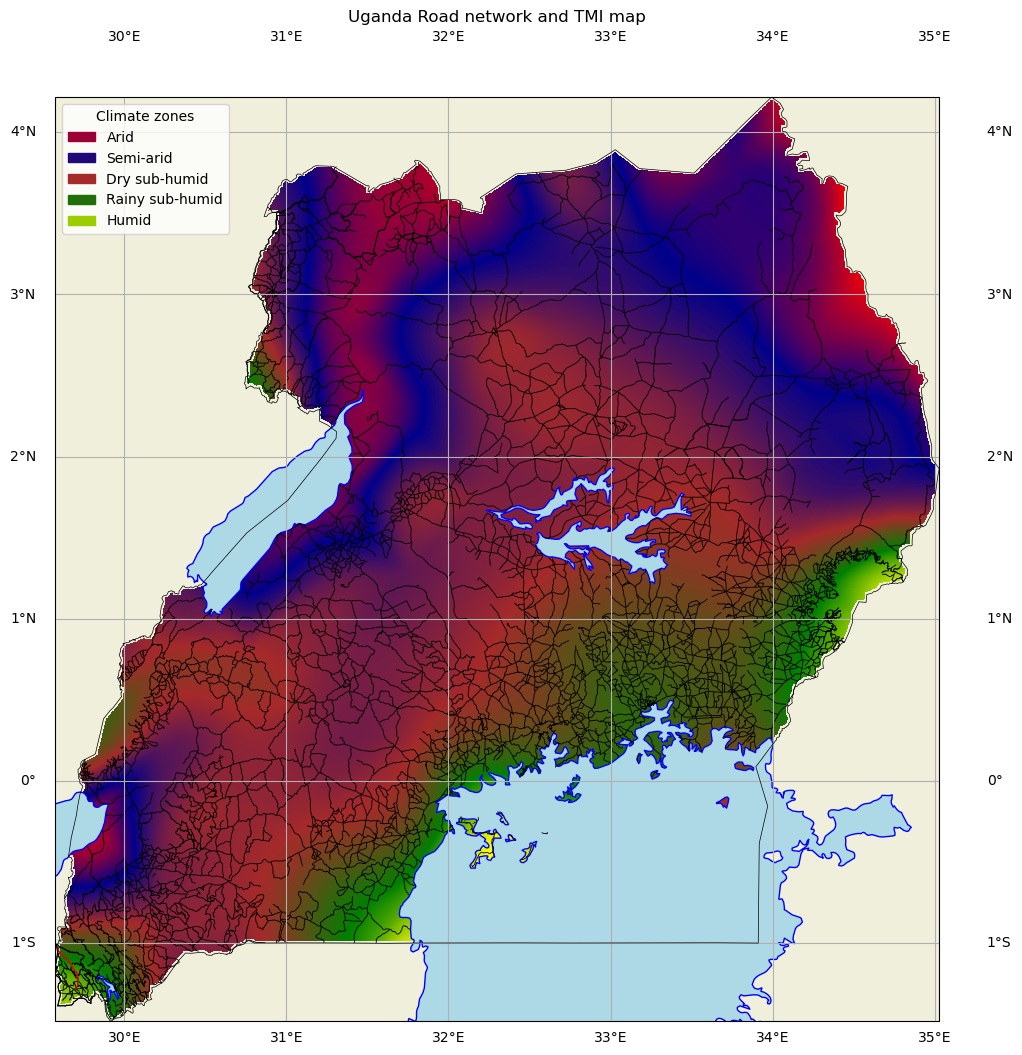

In [51]:
# Load the Uganda boundary shapefile into a GeoDataFrame
# Define the time period
time_period = '2011 - 2020'
data = TMI_data.loc[:, ['Lat', 'Lon', 'tmi']].set_index(['Lat', 'Lon']).to_xarray()
data_min = data['tmi'].min()
data_max = data['tmi'].max()
vmin = data_min
vmax = data_max


# Ensure your point data is in a GeoDataFrame
gdf_points = gpd.GeoDataFrame(TMI_data, geometry=gpd.points_from_xy(TMI_data.Lon, TMI_data.Lat))
gdf_points.crs = "EPSG:4326" 
# Define the bounds of your area of interest and the resolution of the grid
xmin, ymin, xmax, ymax = [29.5, -1.5, 35, 4.5]
grid_x, grid_y = np.mgrid[xmin:xmax:2000j, ymin:ymax:2000j]  # High resolution
# Create a GeoDataFrame for Uganda
uganda = gpd.read_file('/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/Landslides/Data/Boundaries/ug-politicalboundary/ug-politicalboundary.shp')
uganda = uganda.to_crs(epsg=4326)
uganda_boundary = uganda.unary_union
# Interpolate the point data to the grid using griddata
point_coords = np.column_stack((gdf_points.geometry.x, gdf_points.geometry.y))
grid_z = griddata(point_coords, gdf_points['tmi'], (grid_x, grid_y), method='cubic')
# Create a boolean mask for all points inside the Uganda boundary
inside_uganda = np.array([Point(x, y).within(uganda_boundary) for x, y in zip(np.ravel(grid_x), np.ravel(grid_y))])
inside_uganda = inside_uganda.reshape(grid_x.shape)
# Apply the mask to the grid data to set values outside Uganda to NaN
grid_z_masked = np.where(inside_uganda, grid_z, np.nan)
# Create the colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    name='custom_risk_map',
    colors=['red', 'darkblue', 'brown', 'green', 'yellow']
)
norm = mcolors.Normalize(vmin=0, vmax=1)  # Assuming landslide probability is between 0 and 1
# Plotting
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
cax = ax.imshow(grid_z_masked.T, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap=cmap, transform=ccrs.PlateCarree(), interpolation='bicubic')





# Add lakes, land, and coastline features
ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='blue')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)






#Add road data 
road = gpd.read_file('/Users/pamelaacheng/Library/CloudStorage/OneDrive-Personal/Documents/Trainings/GIS/GIS/GIS Fundamentals Data/Ug_Roads_UNRA_2012.shp')
# Ensure everything is in the same CRS (WGS84 - EPSG:4326)
if road.crs != 'EPSG:4326':
    road = road.to_crs('EPSG:4326')
if uganda.crs != 'EPSG:4326':
    uganda = uganda.to_crs('EPSG:4326')

# Get the bounds of the Uganda boundary to set the extent of the plot
bounds = uganda.total_bounds  # [minx, miny, maxx, maxy]

# Plot the map using 'TMI' and the specified colormap
#fig, ax = plt.subplots(figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})
#data.tmi.plot.pcolormesh(ax=ax, vmin=vmin, vmax=vmax)


# Plot the roads
road.plot(ax=ax, color='black', linewidth=0.6)
#Plot Uganda boundary
uganda.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

#Add kisoro district boundary
kisoro_boundary = gpd.read_file('/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/HDM4/Technical note/Road data/kisoro.shp')
kisoro_roads = gpd.read_file('/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/HDM4/Technical note/Road data/Kisoro roads.shp')
# Ensure everything is in the same CRS (WGS84 - EPSG:4326)
if kisoro_roads.crs != 'EPSG:4326':
    kisoro_roads = kisoro_roads.to_crs('EPSG:4326')
if kisoro_boundary.crs != 'EPSG:4326':
    kisoro_boundary = kisoro_boundary.to_crs('EPSG:4326')
# Specify the name of the road you want to highlight
road_name = "Kisoro - Nyabwishenya - Nteko"
# Filter the specific road
selected_road = kisoro_roads[kisoro_roads['ROADNAME'] == road_name]

#Plot the selected road and kisoro district boundary
selected_road.plot(ax=ax, color='red', linewidth=0.8)
kisoro_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8, transform=ccrs.PlateCarree())


# Set the extent to the Uganda boundary
ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], crs=ccrs.PlateCarree())





# Add custom legend for risk categories
legend_patches = [mpatches.Patch(color=cmap(norm(0.1)), label='Arid'),
                  mpatches.Patch(color=cmap(norm(0.3)), label='Semi-arid'),
                  mpatches.Patch(color=cmap(norm(0.5)), label='Dry sub-humid'),
                  mpatches.Patch(color=cmap(norm(0.7)), label='Rainy sub-humid'),
                  mpatches.Patch(color=cmap(norm(0.9)), label='Humid')]
ax.legend(handles=legend_patches, loc='upper left', title='Climate zones')







# Set plot title and other settings
ax.set_title('Uganda Road network and TMI map')
ax.grid(which="both")

# Specify the file path to save the PNG
output = f'/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/HDM4/Technical note/Road data/TMIRoadS_{time_period}.png'

# Save the plot as a PNG with the specified file path
plt.savefig(output, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()


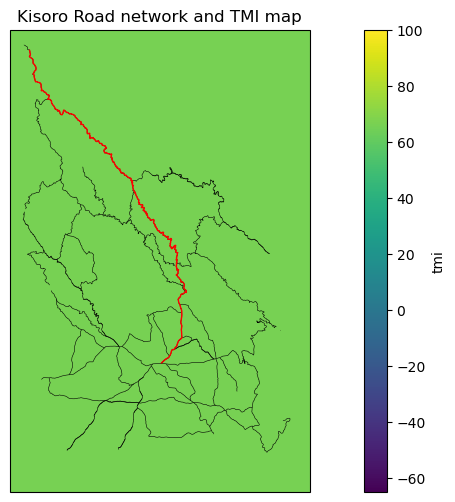

In [52]:
# TMi values for selected road in Uganda
kisoro_boundary = gpd.read_file('/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/HDM4/Technical note/Road data/kisoro.shp')

kisoro_roads = gpd.read_file('/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/HDM4/Technical note/Road data/Kisoro roads.shp')
# Define the time period
time_period = '2011 - 2020'


data = TMI_data.loc[:, ['Lat', 'Lon', 'tmi']].set_index(['Lat', 'Lon']).to_xarray()
data_min = data['tmi'].min()
data_max = data['tmi'].max()

vmin = data_min
vmax = data_max

# Ensure everything is in the same CRS (WGS84 - EPSG:4326)
if kisoro_roads.crs != 'EPSG:4326':
    kisoro_roads = kisoro_roads.to_crs('EPSG:4326')
if kisoro_boundary.crs != 'EPSG:4326':
    kisoro_boundary = kisoro_boundary.to_crs('EPSG:4326')

# Get the bounds of the Uganda boundary to set the extent of the plot
bounds = kisoro_boundary.total_bounds  # [minx, miny, maxx, maxy]

# Specify the name of the road you want to highlight
road_name = "Kisoro - Nyabwishenya - Nteko"
# Filter the specific road
selected_road = kisoro_roads[kisoro_roads['ROADNAME'] == road_name]


# Plot the map using 'TMI' and the specified colormap
fig, ax = plt.subplots(figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})

data.tmi.plot.pcolormesh(ax=ax, vmin=vmin, vmax=vmax)

# Plot all roads
kisoro_roads.plot(ax=ax, color='black', linewidth=0.4)
# Highlight the specific road
selected_road.plot(ax=ax, color='red', linewidth=1.0)  # Adjust color and linewidth as needed
#Plot kisoro boundary
kisoro_boundary.plot(ax=ax, color='black', linewidth=0.4)

# Set the extent to the Uganda boundary
ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], crs=ccrs.PlateCarree())

# Set plot title and other settings
ax.set_title('Kisoro Road network and TMI map')
ax.grid(which="both")

# Specify the file path to save the PNG
output = f'/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/HDM4/Technical note/Road data/TMIKisoroRoad_{time_period}.png'

# Save the plot as a PNG with the specified file path
plt.savefig(output, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()


In [99]:
from PIL import Image #to create gif
import os #to create gif
import glob #access the directory
import imageio
import imageio.v3 as iio
from pathlib import Path

In [103]:
#Create GIF

# Directory path containing your PNG files
directory = '/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/HDM4/TMI/Flood maps'

images = list()
for file in sorted(Path(directory).iterdir()):  # Sort the files
    if not file.is_file():
        continue

    # Skip .DS_Store files
    if file.name == ".DS_Store":
        continue

    images.append(str(file))  # Convert the Path object to a string

# Specify the output GIF file
output_gif = '/Users/pamelaacheng/Library/CloudStorage/OneDrive-Nexus365/DPhil/2022/HDM4/TMI/TMI maps/TMIFloodavg.gif'

# Create a GIF from the list of PNG file paths
with imageio.get_writer(output_gif, mode='I', duration=2) as writer:
    for image in images:
        frame = imageio.imread(image)  # Read the image directly
        writer.append_data(frame)

print("GIF created successfully!")


/var/folders/pr/_06pztgj1tvf2n01hdjmhbxc0000gn/T/ipykernel_23730/2675949120.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image)  # Read the image directly


GIF created successfully!
